In [4]:
include("../optimizers/trustregion.jl")
include("../utils/functions.jl")
using Gadfly

## Trust region overview
Recall the quadratic model:
$$m_k(p) = f_k + g_k^\top p + p^\top B_k p.$$

We first solve the trust region subproblem
$$\min_p m_k(p) \text{ s.t. } ||p|| \leq \Delta_k,$$
where $\Delta_k$ is the trust region radius.

We define the following ratio at each iteration $k$:
$$ \rho_k = \frac{f(x_k) - f(x_k + p_k) }{ m_k(0) - m_k(p)  },$$
where the numerator gives the actual reduction, difference of the function at the current step and the next step,
and the denominator is the predicted  reduction, i.e., the reduction in $f$ predicted by the model function.

The predicted reduction $m_k(0) - m_k(p)$ is always nonnegative. So, the value of the actual reduction tells us how to adjust the trust region model. If the actual reduction
$$f(x_k) - f(x_k + p_k) < 0,$$ then the new objective value $f(x_k + p_k)$ is greater than the current value of $f(x_k)$, so this step should be rejected.

Otherwise, if the actual reduction is highly positive, we can increase the trust region. If it's close to zero or negative, we want to decrease the trust region. If the ratio is close to 1, that means the model agrees well with the function, and we keep the ratio the same. That gives rise to the trust region algorithm.

## Approximate solutions for solving the trust-region subproblem

Although we'd ideally solve the subproblem for the step $p$ exactly, to get global convergence, we only need to solve it approximately such that we get a sufficient reduction in the model. 

### The Cauchy point

We can quantify this in terms of the Cauchy point, denoted as $p_k^c := \tau_k p_k^s$, where $p_k^s$ is the vetor that solves the linear version of the subproblem
$$p_k^s = \arg\min_p f_k + g_k^T p \text{ s.t. } ||p|| \leq \Delta_k,$$
and $\tau_k >0$ minimizing the model $m_k(\tau p_k^s)$ such that it satisfies the trust-region bound
$$\tau_k = \arg\min_{\tau > 0} m_k(\tau p_k^s) \text{ s.t. } ||\tau p_k^s|| \leq \Delta_k.$$

The closed form-expression is given by
$$p_k^c = -\tau_k \frac{\Delta_k}{||g_k||} g_k,$$
where 
$$\tau_k = 
    \begin{cases}
    1 & \text{ if } g_k^\top B_k g_k \leq 0 \\
    \min(||g_k||^3/(\Delta_k g_k^\top B_k g_k), 1) &\text{ otherwise }
    \end{cases}  
$$

While the Cauchy step is inexpensive to compute and leads to a globally convergent trust-region method, it performs poorly even if an optimal step length is used at each iteration, as it is essentially the steepest descent method with a particular step length.


### The dogleg method

The dogleg method combines two steps:
\begin{align*}
 p^B &= -B^{-1} g \\
 p^U &= -\frac{g^\top g}{g^\top B g} g
\end{align*}

The dogleg path has the following trajectory:
\begin{align*}
\tilde{p}(\tau) = 
\begin{cases}
    \tau p^U & 0 \leq \tau \leq 1 \\
    p^U + (\tau-1)(p^B - p^U) 1&\leq\tau\leq 2
\end{cases}
\end{align*}

We can compute $\tau$ by solving the following scalar quadratic equation:
$$||p^U + (\tau-1) (p^B - p^U) ||^2 = \Delta^2,$$
which we can solve using the quadratic formula.

# Testing the optimization methods 

## Fenton's function

In [48]:
xvals = trust_region([3.;4.], 6, 1, 0.1, fenton, fenton_g, fenton_h, 2000, "dogleg");
println(xvals[end])

Number of indefinite fixes 0
Number of iterations: 6
[1.7434520869871946,2.0296947100002467]


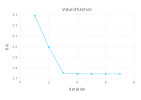

In [49]:
nsamps = length(xvals)
fx = [fenton(xvals[i]) for i in 1:nsamps]
Gadfly.plot(x=1:nsamps, y=fx, Geom.point, Geom.line, 
Guide.xlabel("iteration"), Guide.ylabel("f(x)"), Guide.title("Value of function"))

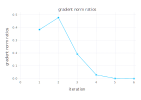

In [51]:
nsamps = length(xvals)
grads = [norm(fenton_g(xvals[i]), 2) for i in 1:nsamps]
Gadfly.plot(x=1:nsamps-1, y=grads[2:nsamps,:]./grads[1:nsamps-1,:], Geom.point, Geom.line, 
Guide.xlabel("iteration"), Guide.ylabel("gradient norm ratios"), Guide.title("gradient norm ratios"))

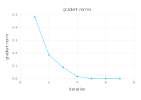

In [52]:
Gadfly.plot(x=1:nsamps, y=grads, Geom.point, Geom.line, 
    Guide.xlabel("iteration"), Guide.ylabel("gradient norm"), Guide.title("gradient norms"))

## Rosenbrock function

The Rosenbrock function is defined by:
$$f(x) = \sum_{i=1}^n [ (1-x_{2i-1})^2 + 10(x_{2i} - x_{2i-1}^2)^2 ]$$


In [38]:
xvals = trust_region(randn(100), 6, 3, 0.1, rosenbrock, rosenbrock_g, rosenbrock_h, 1000, "dogleg");

Number of indefinite fixes 26

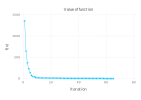


Number of iterations: 64


In [39]:
nsamps = length(xvals)
fx = [rosenbrock(xvals[i]) for i in 1:nsamps]
Gadfly.plot(x=1:nsamps, y=fx, Geom.point, Geom.line, 
Guide.xlabel("iteration"), Guide.ylabel("f(x)"), Guide.title("Value of function"))

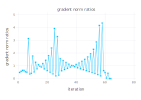

In [42]:
nsamps = length(xvals)
grads = [norm(rosenbrock_g(xvals[i]), 2) for i in 1:nsamps]
Gadfly.plot(x=1:nsamps-1, y=grads[2:nsamps,:]./grads[1:nsamps-1,:], Geom.point, Geom.line, 
Guide.xlabel("iteration"), Guide.ylabel("gradient norm ratios"), Guide.title("gradient norm ratios"))

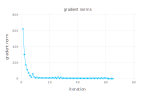

In [41]:
Gadfly.plot(x=1:nsamps, y=grads, Geom.point, Geom.line, 
    Guide.xlabel("iteration"), Guide.ylabel("gradient norm"), Guide.title("gradient norms"))

## Cute function

The cute function is given by $f: \mathbb{R}^n \rightarrow \mathbb{R}$
$$ f(x) = \sum_{i=1}^{n-4} (-4x_i+3)^2 + (x_i^2 + 2x_{i+1}^2 + 3x_{i+2}^2 + 4 x_{i+3}^2 + 5x_n^2)^2 $$

In [43]:
xvals = trust_region(ones(50)*10, 6, 3, 0.1, cute, cute_g, cute_h, 2000, "dogleg");

Number of indefinite fixes 16
Number of iterations: 16


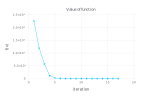

In [44]:
nsamps = length(xvals)
fx = [cute(xvals[i]) for i in 1:nsamps]
Gadfly.plot(x=1:nsamps, y=fx, Geom.point, Geom.line, 
Guide.xlabel("iteration"), Guide.ylabel("f(x)"), Guide.title("Value of function"))

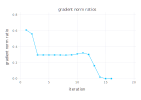

In [45]:
nsamps = length(xvals)
grads = [norm(cute_g(xvals[i]), 2) for i in 1:nsamps]
Gadfly.plot(x=1:nsamps-1, y=grads[2:nsamps,:]./grads[1:nsamps-1,:], Geom.point, Geom.line, 
Guide.xlabel("iteration"), Guide.ylabel("gradient norm ratio"), Guide.title("gradient norm ratios"))

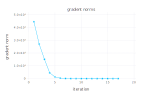

In [47]:
Gadfly.plot(x=1:nsamps, y=grads, Geom.point, Geom.line, 
    Guide.xlabel("iteration"), Guide.ylabel("gradient norm"), Guide.title("gradient norms"))